# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *S*

**Names:**

* *Adam Cohen*
* *Stefan Peters*
* *Alexandre Spiess*
* *Tom Oliver Martin Vrakking*

---

#### Instructions

*This is a template for part 3 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.3 Epdemics

#### Exercise 2.9: Simulate an epidemic outbreak

In [89]:
# Imports
import epidemics_helper
import json
import math
import networkx as nx
from networkx.readwrite import json_graph
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [90]:
# Part 1.

# Open the JSON file
with open("../data/nyc_augmented_network.json", "r") as f:
    data = json.load(f)
    
# Create the graph from the data
G = json_graph.node_link_graph(data)

# Set epidemic parameters
beta = 10
gamma = 0.1 
source_node = 23654 
simulation_days = 100

# Run the simulation
sir = epidemics_helper.SimulationSIR(G, beta=beta, gamma=gamma)
sir.launch_epidemic(source_node, max_time=simulation_days)

Epidemic stopped after 101.72 days | 101.72 days elapsed | 0.1% susceptible, 0.0% infected, 99.9% recovered


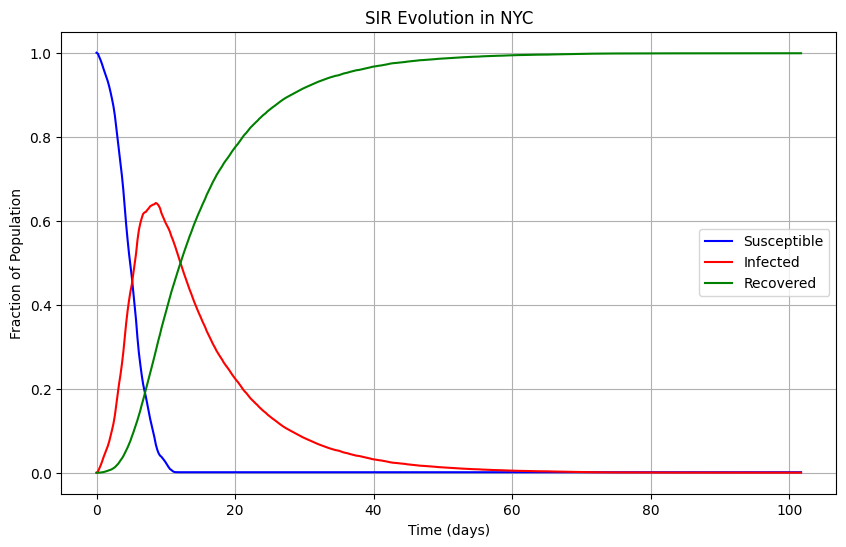

In [91]:
# Part 2.

time_steps = np.linspace(0, sir.max_time, num=500)

# Get the status node for each node at each time
status_over_time = np.array([
    [sir.get_node_status(n, t) for n in range(sir.n_nodes)]
    for t in time_steps
])

# Compute fractions of susceptible, infected, and recovered nodes at each time 
susceptible = np.mean(status_over_time == 0, axis=1)
infected = np.mean(status_over_time == 1, axis=1)
recovered = np.mean(status_over_time == 2, axis=1)

# Plot epidemic evolution over time
plt.figure(figsize=(10, 6))
plt.plot(time_steps, susceptible, label="Susceptible", color="blue")
plt.plot(time_steps, infected, label="Infected", color="red")
plt.plot(time_steps, recovered, label="Recovered", color="green")
plt.xlabel("Time (days)")
plt.ylabel("Fraction of Population")
plt.title("SIR Evolution in NYC")
plt.legend()
plt.grid()
plt.show()

In [92]:
# Part 3.

# Find the first time when at least 60% are infected
time_infected = time_steps[np.argmax(infected >= 0.6)]

# Find the first time when at least 60% are recovered
time_recovered = time_steps[np.argmax(recovered >= 0.6)]

print(f"Time to reach 60% infected : {time_infected} days")
print(f"Time to reach 60% recovered: {time_recovered} days")


Time to reach 60% infected : 6.5231201764678355 days
Time to reach 60% recovered: 14.47317289153801 days


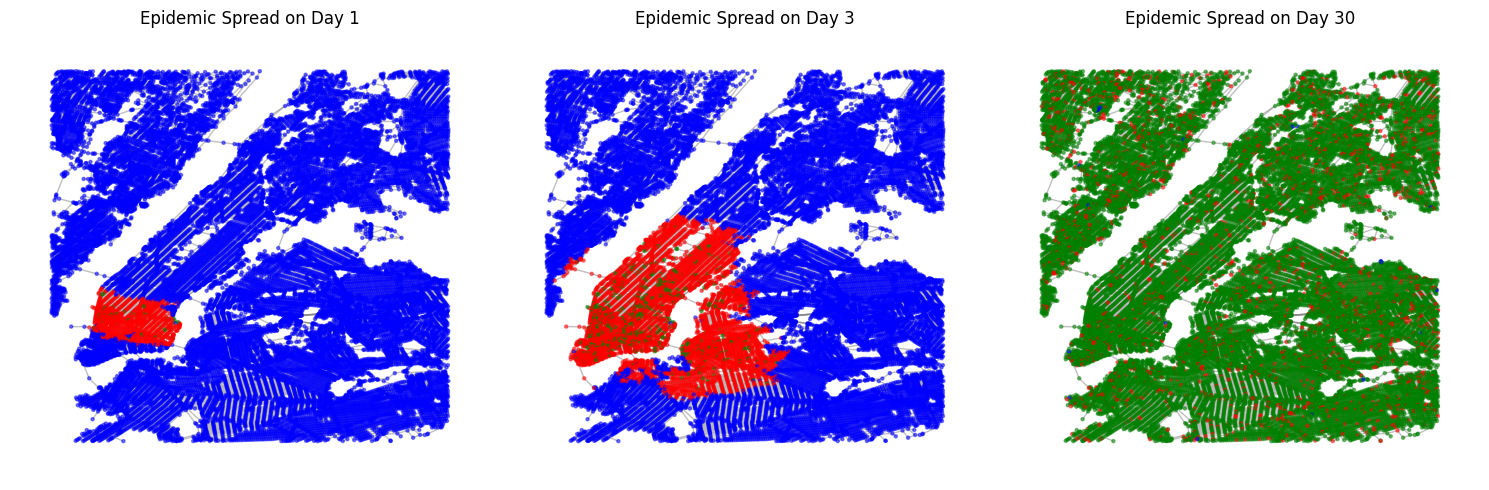

In [93]:
# Part 4.

days_to_plot=[1, 3, 30]
node_positions = nx.get_node_attributes(G, "coordinates")
color_map = np.array(["blue", "red", "green"])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through selected days and plot the epidemic spread
for i,day in enumerate(days_to_plot):
   
    node_states = status_over_time[np.argmax(time_steps >= day)]
    node_colors = color_map[node_states]

    ax = axes[i]
    nx.draw(G,pos=node_positions,node_color=node_colors,node_size=5,edge_color="gray",alpha=0.5,with_labels=False, ax=ax)
    ax.set_title(f"Epidemic Spread on Day {day}")

# Show the graphs
plt.tight_layout()
plt.show()

On day 1, the epidemic has already progressed rapidly.   
On day 3, the epidemic has progressed even more and the first recoveries appear.   
On day 30, almost the entire population has been infected and has recovered.

This graph shows that the epidemic is extremely fast and contaminates almost the entire population. 
This is normal because the infection rate (beta = 10) is very high.

---

### 2.3.1 Stop the apocalypse!

#### Exercise 2.10: Strategy 1

In [94]:
def plot_epidemic_spread(sir, G_copy, days_to_plot=[1, 10, 15, 20, 30, 50]):
    """Plot the epidemic spread"""
    time_steps = np.linspace(0, sir.max_time, num=200)
    
    # Get the status node for each node at each time
    status_over_time = np.array([
        [sir.get_node_status(n, t) for n in range(sir.n_nodes)]
        for t in time_steps
    ])
    
    node_positions = nx.get_node_attributes(G_copy, "coordinates")
    color_map = np.array(["blue", "red", "green"])

    n = len(days_to_plot)
    ncols = 3
    nrows = math.ceil(n/3) 
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 10))
    
    # Loop through selected days and plot the epidemic spread
    for i ,day in enumerate(days_to_plot):
    
        node_states = status_over_time[np.argmax(time_steps >= day)]
        node_colors = color_map[node_states]

        ax = axes[int (i/ncols), i%ncols]
        
        nx.draw(G_copy,pos=node_positions,node_color=node_colors,node_size=5,edge_color="gray",alpha=0.5,with_labels=False, ax=ax)
        #pos=node_positions
        ax.set_title(f"Epidemic Spread on Day {day}")
    
    # Show the graphs
    plt.tight_layout()
    plt.show()

In [95]:
def simulate_epidemic_with_removed_edges(G, beta, gamma, simulation_days, num_edges_to_remove, day, num_simulations, strategy, plot=False):
    """Simulates an SIR epidemic model on a given graph after removing a number of edges."""

    # Initialize result arrays
    susceptible = np.zeros(num_simulations)
    infected = np.zeros(num_simulations)
    recovered = np.zeros(num_simulations)

    # To plot the last simulation
    last_sir = None
    last_G = None

    for i in range(num_simulations):
        # Copy the original graph
        G_copy = G.copy()
    
        # Select a random source node
        source_node = np.random.choice(list(G_copy.nodes))
    
        # Use a strategy for removing edge
        edges_to_remove = strategy(G_copy, num_edges_to_remove)
        G_copy.remove_edges_from(edges_to_remove) 
    
        # Run the SIR simulation
        sir = epidemics_helper.SimulationSIR(G_copy, beta=beta, gamma=gamma, verbose=False)
        sir.launch_epidemic(source_node, max_time=simulation_days)

        # To plot the last simulation
        last_sir = sir
        last_G = G_copy
    
        # Get node statuses on the specified day
        status_on_day = np.array([sir.get_node_status(n, day) for n in range(sir.n_nodes)])
    
        # Count the number of nodes in each state
        susceptible[i] = np.sum(status_on_day == 0)
        infected[i] = np.sum(status_on_day == 1)
        recovered[i] = np.sum(status_on_day == 2)

        # Compute average results
        mean_susceptible = np.mean(susceptible)
        mean_infected = np.mean(infected)
        mean_recovered = np.mean(recovered)

    print(f"Average results over {num_simulations} simulations on day {day} with {num_edges_to_remove} number edges removed:\n")
    print(f"Average number of healthy people: {mean_susceptible} ({mean_susceptible/G.number_of_nodes() *100} %)")
    print(f"Average number of infected people: {mean_infected} ({mean_infected/G.number_of_nodes() *100} %)")
    print(f"Average number of recovered people: {mean_recovered} ({mean_recovered/G.number_of_nodes() *100} %)\n")

    # Plot the epidemic spread for the last simulation
    if plot :
        plot_epidemic_spread(last_sir, last_G)

In [96]:
def strategy1(G_copy, num_edges_to_remove):
    edges = np.array(G_copy.edges())
    edges_removed = edges[np.random.choice(edges.shape[0], num_edges_to_remove, replace=False)]
    return edges_removed

In [97]:
# 1000 edges to remove

# Define epidemic parameters
beta = 10.0
gamma = 0.1
simulation_days = 100
num_edges_to_remove = 1000
day = 30
num_simulations = 10  

# Display final results
simulate_epidemic_with_removed_edges(G, beta, gamma, simulation_days, num_edges_to_remove, day, num_simulations,strategy1)

Average results over 10 simulations on day 30 with 1000 number edges removed:

Average number of healthy people: 113.2 (0.4274763037649636 %)
Average number of infected people: 2762.9 (10.433518371662702 %)
Average number of recovered people: 23604.9 (89.13900532457234 %)



In [98]:
# 10'000 edges to remove

# Define epidemic parameters
beta = 10.0
gamma = 0.1
simulation_days = 100
num_edges_to_remove = 10000
day = 30
num_simulations = 10  

# Display final results
simulate_epidemic_with_removed_edges(G, beta, gamma, simulation_days, num_edges_to_remove, day, num_simulations, strategy1)

Average results over 10 simulations on day 30 with 10000 number edges removed:

Average number of healthy people: 8623.0 (32.562969676371736 %)
Average number of infected people: 2739.3 (10.344397870171067 %)
Average number of recovered people: 15118.7 (57.092632453457206 %)



##### Interpretation 

The strategy of randomly removing 1000 edges is not effective. There are less than 1% of uninfected people on day 30. 

On the other hand, removing 10'000 edges works well with an average of 45% of uninfected on day 30. 
However 10'000 edges represents about 23% of the edges which is a very substantial part and therefore not a very optimal strategy.

#### Exercise 2.11: Strategy 2

With this strategy we will use the fact that New York is composed of different regions connected by bridges.
The goal will be to cut these bridges to contain the epidemic in a region of New York.  
For this we will assume that a bridge has two properties in a graph :
1. the distance between 2 nodes is large
2. the degree of the nodes is 2 (because a bridge is a straight line A-B-C

In [99]:
def strategy2(G_copy, num_edges_to_remove):

    # Get node with degree == 2 
    nodes_degree_2 = [node for node, deg in G_copy.degree() if deg == 2]
    
    # Compute the geographic distance for edges
    edge_lengths = {}

    # Use a set to track processed edges
    processed_edges = set()
    
    for node in nodes_degree_2:
        for edge in G_copy.edges(node):
            u, v = edge

            # Ensure each edge is only take once
            if (v, u) in processed_edges or (u, v) in processed_edges:
                continue  
            
            # Get node positions (latitude, longitude)
            coord_u = G_copy.nodes[u]["coordinates"]
            coord_v = G_copy.nodes[v]["coordinates"]
            
            dist = ((coord_u[0] - coord_v[0])**2 + (coord_u[1] - coord_v[1])**2)**0.5
            edge_lengths[edge] = dist
            processed_edges.add((u, v))
    
    # Sort edges by length (longest first)
    sorted_edges = sorted(edge_lengths, key=edge_lengths.get, reverse=True)
    
    return sorted_edges[:num_edges_to_remove]

Average results over 10 simulations on day 30 with 2500 number edges removed:

Average number of healthy people: 21089.2 (79.63898644311016 %)
Average number of infected people: 427.5 (1.6143650164268724 %)
Average number of recovered people: 4964.3 (18.746648540462974 %)



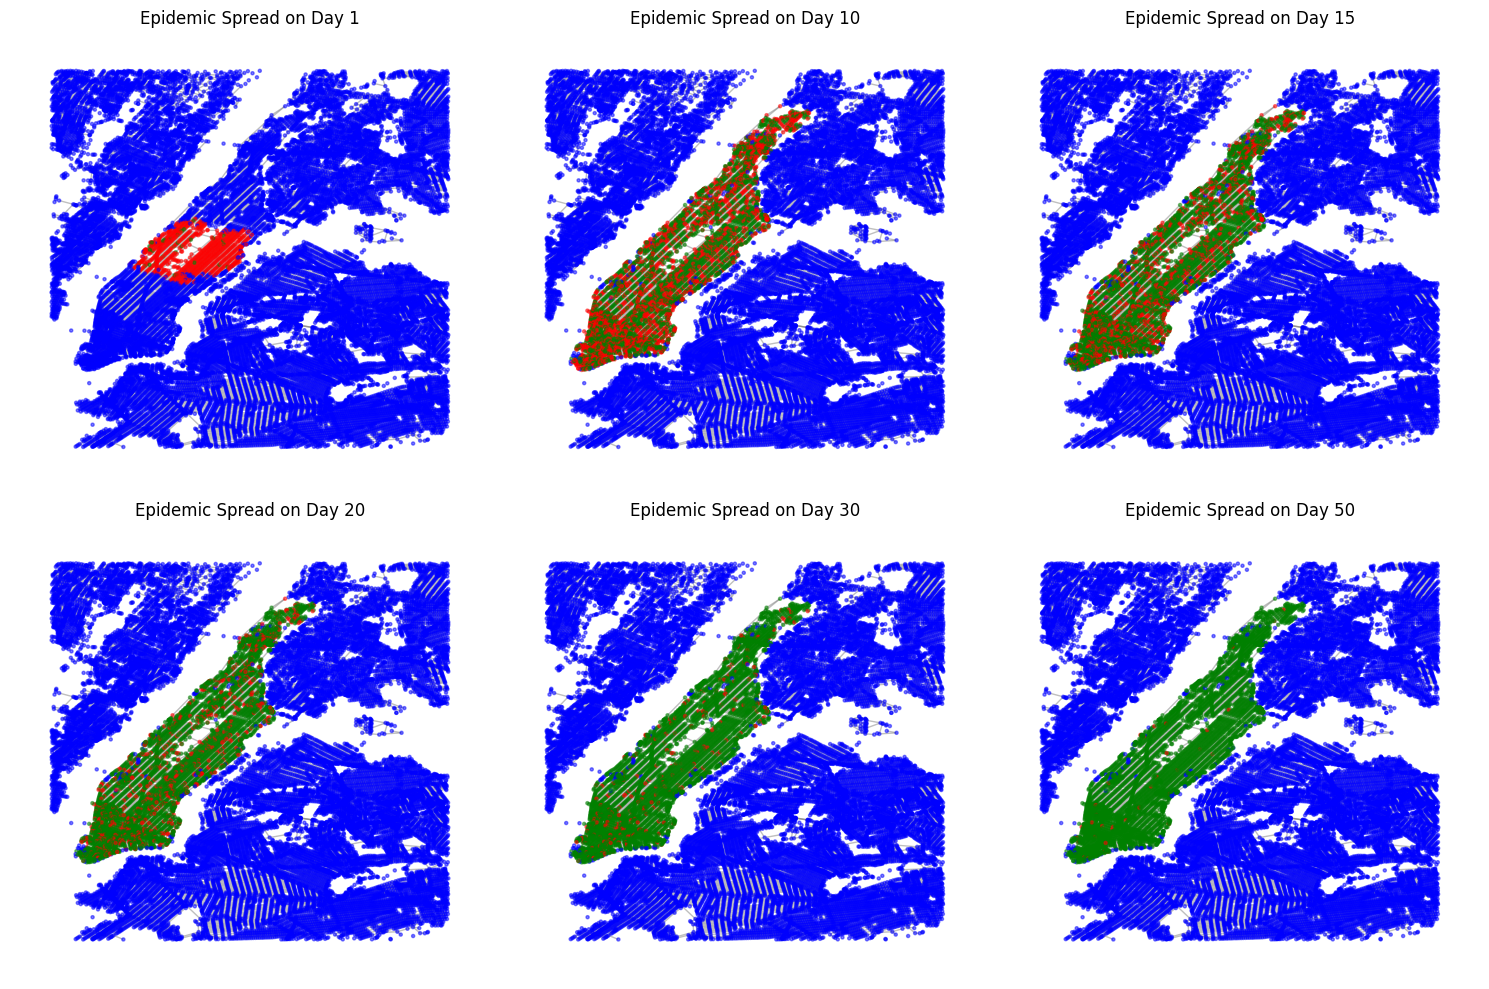

In [100]:
# Define epidemic parameters
beta = 10.0
gamma = 0.1
simulation_days = 100
num_edges_to_remove = 2500
day = 30
num_simulations = 10

# Display final results
simulate_epidemic_with_removed_edges(G, beta, gamma, simulation_days, num_edges_to_remove, day, num_simulations,strategy2, True)

This strategy appears to be an effective strategy with 70% of people still uninfected at day 30. 
Bridges are successfully cut and the pandemic is contained to one region of New York as shown in the pictures. 